

### MSc Data Analytics 

##### CA2 - Integrated Assignment sem2

#### 2020274 - Clarissa Cardoso


##### Github repository: https://github.com/clarissa2020274/2020274_CA2_sem2.git


This Notebook contains experimental features for CA2. The goal of this project is to combine language processing techniques and a time series forecasting to predict the average sentiment of tweets for a certein period of time after the apropriate data cleaning and processing tecniques are applied. The project will be divided into the following sections:

- First section consists of importing dataset from hdfs, and an attemp to evaluate their performance and usability, helping to select the most suitable dataset for the analysis, using spark's distribuited system for processing.

- Second section will focus on data cleaning and preprocessing the dataset.

- Third section focus on deeper EDA features and Natural Language Processing to undertand the dataset better prior to modeling and extract the sentiment from tweets given, such as removing stopwords, special characters etc..


Sections 4 and 5 will be deployed on a separate Jupyter Notebook because of compuational issues within Ubuntu Os.

When attempting to clear space in local disk, a few libraries inicially used for the project were not able to be updated when the system kept freezing for lack of space. The solution found was to reinstall all necessary packages through a virtual enviroment where the new Notebook (2020274_MScDA_CA2_Clarissa_SecondNotebook.ipynb) will be used for experimentation of timeseries contruction. Once the data prepocessing and cleaning was complete, a new file was stored in HDFS and local drive to enable access from multiple sources. 

- Section four centers on creating the time-series model and selection of apropriate parametrers and hyperparameters to run it.

- Fifth section relies on training the model and validating/reacessing features that can be modified for better performance and compare model's results. 








#### Introduction


The goal of this project is to perform an analysis of the given dataset containing several tweets while experimenting with different databases to store data as well as creating a  time series forecast of the sentiment of the dataset. 

For the initial experimentation, after instalation of different noSQL databases as seen in class tutorials, I have decided to start with Hbase. One of the reasons why this was the first database used for the project is that it is built on top of HDFS as a part of Hadoop environment and provides a faster lookup on files while displaying lower latency for queries. 



### Libraries required for project


In [1]:
# importing necessary libraries to deploy pyspark functions

from pyspark.sql import SparkSession
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

from pyspark.sql.functions import count # Funcion to get the "size" of the data.
from pyspark.sql.functions import when # When function.
from pyspark.sql.functions import col # Function column.
from pyspark.sql.functions import mean, min, max, stddev # Imports function for statistical features. 
from pyspark.sql import functions as F # Data processing framework.
from pyspark.sql.functions import size, split # Imports function size and split.
from pyspark.ml.feature import Tokenizer # Importing Tokenizer.
from pyspark.sql.functions import regexp_replace # Remove / Replace function.
from pyspark.sql.types import StructField, StructType # Importing features for Schema.
from pyspark.sql.types import IntegerType, StringType, TimestampType # Tools to create the schema.
from pyspark.sql.functions import udf # Imports function UDF (user defined functions).
from pyspark.sql.types import ArrayType, StringType
from pyspark.ml.linalg import VectorUDT
from pyspark.sql.functions import max as max_


from pyspark.ml import Pipeline
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, StringIndexer, CountVectorizer, NGram, VectorAssembler, ChiSqSelector

from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType
from bs4 import BeautifulSoup  # For HTML parsing
from pyspark.sql.functions import lower

import numpy as np # for numerical operations.
import pandas as pd

import matplotlib.pyplot as plt # visualization
%matplotlib inline 

import nltk # natural language toolkit for language processing
#nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
#nltk.download('wordnet')
#nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


import warnings # Ignore warnings.
warnings.filterwarnings("ignore")



In [10]:
#from sklearn.preprocessing import RobustScaler, PowerTransformer # Importing scalling tools.
#from statsmodels.tsa.seasonal import seasonal_decompose # Imports seasonal decompose for time-series analysis.
#from statsmodels.tsa.stattools import adfuller # Statistical approach for stationarity.
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Auto-correlation plots for time-series analysis.
#from statsmodels.tsa.ar_model import AutoReg # Imports Auto Regressive
#from sklearn.metrics import mean_squared_error, mean_absolute_error # Imports metrics for evaluation.
from scipy import stats # Stats is for Shapiro test (normality).
#from statsmodels.tsa.arima.model import ARIMA # ARIMA time series model.
#from statsmodels.tsa.statespace.sarimax import SARIMAX# Imports SARIMA
import itertools # For hyper-parameter tunning.
#import pmdarima as pm # Imports pmdarima to find optimal order values.
#from pmdarima import auto_arima # Imports auto_arima for optimal parameters.


#### Importing dataset from HDFS

My initial idea, once the dataset given was succesfuly stored in HDFS directory alocated for the CA development ("CA2/ProjectTweets.csv"), was to import it straighaway to a noSQL database and perform initial queries inside the HBase enviroment/shell to verify functionality.

However my VM had continuous crashes during this process, and the HMaster node managed by Zookeeper kept showing slower times for initializing the commands. After a few seconds the Zookeeper Connection with HDFS and Hase nodes was lost and it was taking me a longer time span to find an alternative. Since the csv file was already in hadoop, I decided to first import from HDFS and the perform some initial cleaning and EDA using Spark framework to process the data to then store the cleneaded data back to HBAse through a connector between Pyspark and the database.


- HDFS (Hadoop Distributed File System) is the primary storage system used by Hadoop applications. This open source framework works by rapidly transferring data between nodes. It's often used by companies who need to handle and store big data. <https://www.databricks.com/glossary>

## Import modules, create Spark Session and read file into dataframe

First step is to perform some basic exploratory data analysis to get a sense of the data. 

#### Check the first few rows of the dataset with .show()

File was imported with a header marked as 'false' so pyspark will input labels insted of using the first row. This makes room to rename the labels in coming steps. set up schema as true so pyspark utilises the same scema present in the original file, without overlapping the columns.



In [6]:
from pyspark.sql import SparkSession

# Initialize SparkSession including Legacy for timestamp
spark = SparkSession.builder.appName("Test Tweets")\
    .config("spark.sql.legacy.timeParserPolicy", "LEGACY")\
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:5.1.4")\
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .config("spark.kryo.registrator", "com.johnsnowlabs.nlp.serialization.SparkNLPKryoRegistrator") \
    .getOrCreate()

# Define the file path in HDFS
file_path = "hdfs:///user/hduser/CA2/ProjectTweets.csv"

# Read the CSV file
tweets_test = spark.read.csv(file_path, header=False, inferSchema=True)

# Show the DataFrame (optional)
tweets_test.show()


+---+----------+--------------------+--------+---------------+--------------------+
|_c0|       _c1|                 _c2|     _c3|            _c4|                 _c5|
+---+----------+--------------------+--------+---------------+--------------------+
|  0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|  1|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|  2|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|  3|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|  4|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
|  5|1467811372|Mon Apr 06 22:20:...|NO_QUERY|       joy_wolf|@Kwesidei not the...|
|  6|1467811592|Mon Apr 06 22:20:...|NO_QUERY|        mybirch|         Need a hug |
|  7|1467811594|Mon Apr 06 22:20:...|NO_QUERY|           coZZ|@LOLTrish hey  lo...|
|  8|1467811795|Mon Apr 06 22:20:...|NO_QUERY|2Hood4Hollywood|@Tatiana_K nop

#### Checking the schema of the dataset

From this function we see most of the data is composed by strings, which makes sense, since we are working with mostly text. However, on the third column, with the dates of each tweet, we must have a datetime datatype in order to perform the timeseries analysis on further stages. 



In [7]:
# print schema
tweets_test.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- _c1: long (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: string (nullable = true)
 |-- _c5: string (nullable = true)



In [8]:
# get summary statistics
#tweets_test.describe().show()

### Part I : Data Pre-Processing and Cleaning


Rename cols and drop c1

Convert the date column to a timestamp format

In [9]:
from pyspark.sql.functions import to_timestamp

tweets_test = tweets_test.drop("_c1") \
           .withColumnRenamed("_c0", "index") \
           .withColumnRenamed("_c2", "date") \
           .withColumnRenamed("_c3", "query_flag") \
           .withColumnRenamed("_c4", "user") \
           .withColumnRenamed("_c5", "text") \

tweets_test.show()

+-----+--------------------+----------+---------------+--------------------+
|index|                date|query_flag|           user|                text|
+-----+--------------------+----------+---------------+--------------------+
|    0|Mon Apr 06 22:19:...|  NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|    1|Mon Apr 06 22:19:...|  NO_QUERY|  scotthamilton|is upset that he ...|
|    2|Mon Apr 06 22:19:...|  NO_QUERY|       mattycus|@Kenichan I dived...|
|    3|Mon Apr 06 22:19:...|  NO_QUERY|        ElleCTF|my whole body fee...|
|    4|Mon Apr 06 22:19:...|  NO_QUERY|         Karoli|@nationwideclass ...|
|    5|Mon Apr 06 22:20:...|  NO_QUERY|       joy_wolf|@Kwesidei not the...|
|    6|Mon Apr 06 22:20:...|  NO_QUERY|        mybirch|         Need a hug |
|    7|Mon Apr 06 22:20:...|  NO_QUERY|           coZZ|@LOLTrish hey  lo...|
|    8|Mon Apr 06 22:20:...|  NO_QUERY|2Hood4Hollywood|@Tatiana_K nope t...|
|    9|Mon Apr 06 22:20:...|  NO_QUERY|        mimismo|@twittera que me ...|

View a sample of the 'date' column, using the sample() function to double check the timezone used before conversion.


In [10]:
# see 10% of date row to see correct timezone before converting
tweets_test.select("date").sample(False, 0.1, seed=42).show()


+--------------------+
|                date|
+--------------------+
|Mon Apr 06 22:20:...|
|Mon Apr 06 22:20:...|
|Mon Apr 06 22:20:...|
|Mon Apr 06 22:22:...|
|Mon Apr 06 22:22:...|
|Mon Apr 06 22:23:...|
|Mon Apr 06 22:23:...|
|Mon Apr 06 22:23:...|
|Mon Apr 06 22:25:...|
|Mon Apr 06 22:26:...|
|Mon Apr 06 22:26:...|
|Mon Apr 06 22:26:...|
|Mon Apr 06 22:26:...|
|Mon Apr 06 22:26:...|
|Mon Apr 06 22:26:...|
|Mon Apr 06 22:27:...|
|Mon Apr 06 22:27:...|
|Mon Apr 06 22:28:...|
|Mon Apr 06 22:28:...|
|Mon Apr 06 22:31:...|
+--------------------+
only showing top 20 rows



In [11]:
# limit to 10 rows of date col.
sample_date_values = tweets_test.select("date").limit(10).collect()
for row in sample_date_values:
    print(row.date)

    #with this we can confirm the PDT - Pacific Day Time for apropriate conversion to timestamp.
    # this may influence further analysis. 

Mon Apr 06 22:19:45 PDT 2009
Mon Apr 06 22:19:49 PDT 2009
Mon Apr 06 22:19:53 PDT 2009
Mon Apr 06 22:19:57 PDT 2009
Mon Apr 06 22:19:57 PDT 2009
Mon Apr 06 22:20:00 PDT 2009
Mon Apr 06 22:20:03 PDT 2009
Mon Apr 06 22:20:03 PDT 2009
Mon Apr 06 22:20:05 PDT 2009
Mon Apr 06 22:20:09 PDT 2009


it's important to account for the PDT timezone used. When converting to datetime, the new schema was in the apropriate datatypes, however when i tried to sample the 'date' rows again i got an error as seen below: 

> <font color='red'> <b>Py4JJavaError:</b> An error occurred while calling o100.showString.
: org.apache.spark.SparkUpgradeException: You may get a different result due to the upgrading of Spark 3.0: Fail to recognize 'EEE MMM dd HH:mm:ss z yyyy' pattern in the DateTimeFormatter. 1) You can set spark.sql.legacy.timeParserPolicy to LEGACY to restore the behavior before Spark 3.0. 2) You can form a valid datetime pattern with the guide from https://spark.apache.org/docs/latest/sql-ref-datetime-pattern.html </font> 

So according to Apache Spark documentation, I added a date parsing from java with SimpleDateFormat class to allow customization of the date format of the strings. For that the timezone needs to be specified to avoid any discrepancies. In this case, PDT is UTC-7 which is represented by 'z' in the Apache datetime patterns doc. 


In [12]:
from pyspark.sql.functions import to_timestamp

tweets_test = tweets_test.withColumn("date", to_timestamp(tweets_test.date, "EEE MMM dd HH:mm:ss z yyyy"))


In [13]:
# print schema
tweets_test.printSchema()

root
 |-- index: integer (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- query_flag: string (nullable = true)
 |-- user: string (nullable = true)
 |-- text: string (nullable = true)



#### Checking for missing values and shape


In [14]:
from pyspark.sql.functions import count, when, col
# Check for missing values in each column
tweets_test.select([count(when(col(c).isNull(), c)).alias(c) for c in tweets_test.columns]).show()

+-----+----+----------+----+----+
|index|date|query_flag|user|text|
+-----+----+----------+----+----+
|    0|   0|         0|   0|   0|
+-----+----+----------+----+----+



In [15]:
# print the sahpe of the dataset
num_rows = tweets_test.count()
num_cols = len(tweets_test.columns)

print(f"Number of Rows: {num_rows}")
print(f"Number of Columns: {num_cols}")

Number of Rows: 1600000
Number of Columns: 5


In [16]:
tweets_test.dropna()  # Drop rows containing NaN values for simplicity
tweets_test.show(5)

+-----+-------------------+----------+---------------+--------------------+
|index|               date|query_flag|           user|                text|
+-----+-------------------+----------+---------------+--------------------+
|    0|2009-04-07 05:19:45|  NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|    1|2009-04-07 05:19:49|  NO_QUERY|  scotthamilton|is upset that he ...|
|    2|2009-04-07 05:19:53|  NO_QUERY|       mattycus|@Kenichan I dived...|
|    3|2009-04-07 05:19:57|  NO_QUERY|        ElleCTF|my whole body fee...|
|    4|2009-04-07 05:19:57|  NO_QUERY|         Karoli|@nationwideclass ...|
+-----+-------------------+----------+---------------+--------------------+
only showing top 5 rows



#### Pyspark has some inbuilt functions for starting tne text processing, such as lowercasing, removing special characters and stopwords. 

The following text data preprocessing steps using PySpark functions are:

Lowercasing: We use the lower() function to convert all text to lowercase.

Removing Special Characters: We use regexp_replace() to remove any characters that are not alphanumeric or whitespace.


The resulting tweets_test will display the preprocessed text in the 'text' column.

PySpark doesn't have built-in support for stemming or lemmatization. To implement these kind of techniques, external libraries such as nltk can be implemented/imported. 
<b>NLTK<b/> provides a wide range of tools and resources for working with human language data, and it can complement Spark's capabilities in certain scenarios. 

However, when i tried to import the nltk functions to my vm, i encountered a series of incompatibility issues. Even after creating a virtual environment i was not able to install the library, and the same happened when i tried to install <b>Sparknlp<b/>, which is the language processing tool whitin the Spark enviroment considered to be the state of the art for a number of functionalities in the NLP area. 

There was also an attempt, as suggested by SparkNLP documentaroin, to inicialize pyspark with the additional packages for language processing but when i tried to import it back to the notebook it would not find the module installed, even when i apply the same command (pyspark --packages com.johnsnowlabs.nlp:spark-nlp_2.12:5.1.4) to the virtual env the packages were installed. A third nlp library was also atempted to import via pip: <b>textblob<b/>
    
#error: externally-managed-environment (#error: externally-managed-environment)

With the command found in stackoverflow (sudo apt install python3-nltk) available at https://askubuntu.com/questions/996185/how-can-i-install-nltk-for-python-3

i was able to go back to my original choice of applying nltk tools for extracting the sentiment of the tweets given.

In [17]:
#pip install beautifulsoup4 using virtual enviroment 'myenv'

### Removing noise from data with Spark's functions: 
- Special characters
- Transform all text data to lower case letters
- Remove numbers, duplicate characters and aditional punctuation 

In [18]:
# Remove URLs
tweets_test = tweets_test.withColumn("text", F.regexp_replace(F.col("text"), "http(s)?://[^\\s]+", ""))

# Remove HTML tags
tweets_test = tweets_test.withColumn("text", F.regexp_replace(F.col("text"), "<[^>]+>", ""))

# Remove mentions (i.e., @username)
tweets_test = tweets_test.withColumn("text", F.regexp_replace(F.col("text"), "@\\w+", ""))

# Convert to lowercase
tweets_test = tweets_test.withColumn('text', lower(tweets_test['text']))

# Remove numbers from the "text" column
tweets_test = tweets_test.withColumn('text', regexp_replace(tweets_test['text'], r'\d+', ''))

# Reduce excessive characters (more than two of the same in a row)
tweets_test = tweets_test.withColumn('text', regexp_replace('text', r'(.)\1{2,}', r'\1\1'))

# Remove punctuation
tweets_test = tweets_test.withColumn('text', regexp_replace(tweets_test['text'], r"[^\w\s]", ""))

tweets_test.select("text").show(truncate=False)

+-----------------------------------------------------------------------------------------------------------+
|text                                                                                                       |
+-----------------------------------------------------------------------------------------------------------+
|   a11 thats a bummer  you shoulda got david carr of third day to do it d                                  |
|is upset that he cant update his facebook by texting it11 and might cry as a result  school today also blah|
| i dived many times for the ball managed to save   the rest go out of bounds                               |
|my whole body feels itchy and like its on fire                                                             |
| no its not behaving at all im mad why am i here because i cant see you all over there                     |
| not the whole crew                                                                                        |
|need a hu

In [19]:
# Drop the 'flag' and 'user' columns
tweets_test = tweets_test.drop('query_flag', 'user')

# Show the result
tweets_test.show(5,truncate=False)

+-----+-------------------+-----------------------------------------------------------------------------------------------------------+
|index|date               |text                                                                                                       |
+-----+-------------------+-----------------------------------------------------------------------------------------------------------+
|0    |2009-04-07 05:19:45|   a11 thats a bummer  you shoulda got david carr of third day to do it d                                  |
|1    |2009-04-07 05:19:49|is upset that he cant update his facebook by texting it11 and might cry as a result  school today also blah|
|2    |2009-04-07 05:19:53| i dived many times for the ball managed to save   the rest go out of bounds                               |
|3    |2009-04-07 05:19:57|my whole body feels itchy and like its on fire                                                             |
|4    |2009-04-07 05:19:57| no its not behaving 

### Write Cleaned dataset in a new csv back to hdfs. 

with code adapted from SparkByExamples[], let's store the cleaned tweets to a new csv file back to hdfs. 
This will be later on imported to mysql for testing different databases. the code will be left eith comments just to protect the vm, and avoid overwriting the files in case the kernel is restarted. 

[] https://sparkbyexamples.com/spark/spark-write-dataframe-to-csv-file/#:~:text=In%20Spark%2C%20you%20can%20save,any%20Spark%20supported%20file%20systems.

In [20]:
# The path in HDFS where  to save the new DataFrame
#new_file_path = "hdfs:///user/hduser/CA2/CleanTweets.csv"

# Save the DataFrame to HDFS as a CSV file
#tweets_test.write.csv(new_file_path, header=True, mode="overwrite")

In [21]:
# The path in HDFS where to store the clean DataFrame
#output_directory = "hdfs:///user/hduser/CA2"

# Save the DataFrames to HDFS as CSV files
#tweets_test.write.csv(f"{output_directory}/CleanTweets", header=True, mode="overwrite")

In [22]:
# Show the result
#tweets_test.show(truncate=False)

## Convert to Pandas dataframe for applying nltk:



Among the main differences between Pandas & PySpark, is that operations on Pyspark run faster than Pandas due to its distributed nature and parallel execution on multiple cores and machines. This means pandas run operations on a single node whereas PySpark runs on multiple machines. When working on a Machine Learning applications manipulating larger datasets, PySpark processes operations many times faster than pandas. In this project case, however, when i tried to implement the Spark-nlp pipeline, and was not able to preoceed due to internal errors, the second option was to use the nltk library to get the sentiment from the tweets. 

According to both documentations (Spark and nltk) they are compatible and be used together but while I was applyting the nktk to my spark session, I kept having a series od erros inside the Linux environment, so I converted my dataset back to a pandas dataframe and was able to continue the analysis. 

It was the trade-off encoutered, to slow down performance but at least get an output to present at the end of the project. Another trade-off involved is betweeen performance and cost when it comes to scaling a cluster in spark, but for the time constraints involved it was left in the original distribution of 4 separate nodes in the vm. 

In terms of sentimental analysis, there is a wide range of libraries available for perfoming the models. 
For this project, I tried to install 3 different libraries: vaderSentiment, Sparknlp and nltk, and faced a few errors in the process, but was able to install only the ladder: nltk which is a non-spark nlp library that require pandas usewr defined functions to work. 
Among the literature found for this project, the majority of sources agree that when working with Spark-native distributed NLP projects, the SparkNLP library is the most popular and comprehensive library, for its open-source caracteristics and functionality. The ability to create a simple pipeline to extract sentiment and perfomr advanced analysis are the reason its considerted to be the "State of the art for language processing". 

The VADER sentiment analyzer is a simple rule-based model that works well for social media text. For a more advanced sentiment analysis, there are also other machine learning-based approaches, such as using pre-trained models like BERT or spaCy, that can offer a more detailed modelling.

Databricks community, available at:  https://community.databricks.com/t5/machine-learning/what-are-best-nlp-libraries-to-use-with-spark/td-p/24033#:~:text=You%20can%20also%20use%20spacy,them%20to%20data%20with%20Spark.


In [23]:
# Convert Spark DataFrame to Pandas DataFrame
pandas_df = tweets_test.toPandas()

# Now 'pandas_df' is a Pandas DataFrame
#  apply NLTK or other Python libraries on 'pandas_df' as needed

In [24]:
display(pandas_df.head())
print(pandas_df.info())

,index,date,text
0,0,2009-04-07 05:19:45,a11 thats a bummer you shoulda got david c...
1,1,2009-04-07 05:19:49,is upset that he cant update his facebook by t...
2,2,2009-04-07 05:19:53,i dived many times for the ball managed to sa...
3,3,2009-04-07 05:19:57,my whole body feels itchy and like its on fire
4,4,2009-04-07 05:19:57,no its not behaving at all im mad why am i he...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 3 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   index   1600000 non-null  int32         
 1   date    1600000 non-null  datetime64[ns]
 2   text    1600000 non-null  object        
dtypes: datetime64[ns](1), int32(1), object(1)
memory usage: 30.5+ MB
None


### Tokenization with Spark functions

this session was left commented since the nltk library was the main choice to perform these function, but the spark tokenization could also have been implemented to compose the pipeline for sentiment analisis.

### Text Preprocessing for sentiment extraction using NLTK library

Text preprocessing is a crucial step in sentiment analysis, facilitating the cleaning and normalization of text data for effective analysis. 
Common techniques include:

- Tokenization: which breaks down text into individual words or tokens,
- Stop word removal:  to eliminate irrelevant words, 
- Stemming and lemmatization for reducing words to their root forms. 

In this project, tokenization of the text column is done with NLTK's word_tokenize function, while stop words can be removed using NLTK's built-in list. Stemming reduces words to base forms by removing suffixes, and lemmatization does the same based on the part of speech. These techniques enhance sentiment analysis accuracy. The bag of words (BoW) model, a natural language processing technique, represents text as numerical features, allowing for analysis with machine learning algorithms.

It was observed a longer time to process this function, so to measure the accurate execution time, a pandas function was added to the preprocess_text function created below:

Original Source: DataCamp NLTK Tutorial (Accessed on 17/11/2023, available at:https://www.datacamp.com/tutorial/text-analytics-beginners-nltk)


In [25]:
#import nltk
#nltk.download('punkt')
#nltk.download('stopwords')
#from nltk.stem import WordNetLemmatizer
#nltk.download('wordnet')
#nltk.download('vader_lexicon')

import time
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer



In [26]:
# Create preprocess_text function
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())

    # Remove stop words
    filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]

    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    # Join the tokens back into a string
    processed_text = ' '.join(lemmatized_tokens)
    return processed_text

# Apply the function to pandas_df and measure the time
start_time = time.time()
pandas_df['text'] = pandas_df['text'].apply(preprocess_text)
elapsed_time = time.time() - start_time

# Print the total execution time
print(f"Total execution time: {elapsed_time} seconds")


#code adapted from Datacamp NLTK Sentiment Analysis Tutorial for Beginners- 
#https://www.datacamp.com/tutorial/text-analytics-beginners-nltk

Total execution time: 1124.5174362659454 seconds


In [27]:
pandas_df.head()

,index,date,text
0,0,2009-04-07 05:19:45,a11 thats bummer shoulda got david carr third day
1,1,2009-04-07 05:19:49,upset cant update facebook texting it11 might ...
2,2,2009-04-07 05:19:53,dived many time ball managed save rest go bound
3,3,2009-04-07 05:19:57,whole body feel itchy like fire
4,4,2009-04-07 05:19:57,behaving im mad cant see


### NLTK sentiment analyzer
The NLTK sentiment analyzer below returns a score between -1 and +1. We have used a cut-off threshold of 0 in the get_sentiment function. Anything above 0 is classified as 1 (meaning positive). 

In datacamp's original code and dataset, they had the actual labels available to perform the confusion matrix and get the classification report to evaluate the performance of the method. In the case of the dataset provided for this project, we only have access to the predicted labels obtained with nltk sentiment analyzer, so when i tried to get a classification report using a similar code, the results seemlengly perfect (1.0 accuracy?) are not really realiable since there are no actual data to compare them with. The classification report has 'perfect' performance because its using only the predicted values for sentiment, instead real data. 

When calculated the Internal Consistency to check the percentage of consistent predictions, the reult of 44.89% indicates that almost half of the predicted sentiment labels are consistent with each other. However, it's important to note that without ground truth labels for comparison, internal consistency alone doesn't provide a complete picture of model performance.


In [28]:
# initialize NLTK sentiment analyzer

analyzer = SentimentIntensityAnalyzer()

# create get_sentiment function
def get_sentiment(text):
    scores = analyzer.polarity_scores(text)
    sentiment = 1 if scores['pos'] > 0 else 0
    return sentiment

# apply get_sentiment function

pandas_df['sentiment'] = pandas_df['text'].apply(get_sentiment)

pandas_df.head()

,index,date,text,sentiment
0,0,2009-04-07 05:19:45,a11 thats bummer shoulda got david carr third day,0
1,1,2009-04-07 05:19:49,upset cant update facebook texting it11 might ...,0
2,2,2009-04-07 05:19:53,dived many time ball managed save rest go bound,1
3,3,2009-04-07 05:19:57,whole body feel itchy like fire,1
4,4,2009-04-07 05:19:57,behaving im mad cant see,0


In [29]:
#Dist of sentiment:

pandas_df['sentiment'].value_counts()

1    881786
0    718214
Name: sentiment, dtype: int64

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(pandas_df['sentiment'], pandas_df['sentiment'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

ImportError: cannot import name 'confusion_matrix' from 'sklearn.metrics' (unknown location)

In [ ]:
#attempt to do a heatmap without confusion matrix?
sns.heatmap(pandas_df['sentiment'], annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Issues with space in Ubuntu + unable to import sklearn library when VM restarted

Before my VM started to freeze due to lack of disk space, I was able to save the figures plotted at the beggining using the sklearn properties installed prior to perform the cleaning cashe and other disk management attempts.

However, once the 'sudo apt get clean' command, or one of the similar ones used, i was not able to restart the kernel with the same libraries. So the code will display a series of erros that I was not able to fix before the deadline, but the orinial confusion matrixes will be present in the report and can be accessed via the version control repository present at the start of this notebook. 


Also, in order to avoid causing anymore constraints to the operational system, restaring the kernel and the notebook will be done with caution to not loose anymore progress. As well as running the sentimental analyser fucntion from nltk takes a lot of resources, so once the sentiment was extracted, the new dataset with only the numeric features was also stored on a new csv file for a easier access on a second notebook. 


In [11]:
#from sklearn import preprocessing, metrics, cross_validation


In [12]:
#!pip install sklearn
#error: externally-managed-environment
from sklearn.metrics import confusion_matrix, classification_report


#I'm sure there is a way of creating the confusion matrix of the data without relying on sklearn metrics


ImportError: cannot import name 'confusion_matrix' from 'sklearn.metrics' (unknown location)

In [36]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# Considering 'sentiment' is the predicted sentiment column
predicted_labels = pandas_df['sentiment']

# Evaluate internal consistency since there are not true lables, only the predicted ones 

# First, if 'sentiment' is binary (0 and 1), you can check the distribution
print("Distribution of Predicted Sentiment:")
print(predicted_labels.value_counts())

# You can use other evaluation metrics as well
# For example, internal consistency (percentage of consistent predictions)
internal_consistency = (predicted_labels == 0).mean()  # Adjust as needed
print(f"\nInternal Consistency: {internal_consistency * 100:.2f}%")

# If 'sentiment' is binary, you can also check the confusion matrix
# and classification report
conf_matrix = confusion_matrix(predicted_labels, predicted_labels)
class_report = classification_report(predicted_labels, predicted_labels)

print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

ImportError: cannot import name 'accuracy_score' from 'sklearn.metrics' (unknown location)

### Adding a third label for display neutrality between the polarised thresholds

With the same function for sentimental analyzer, but adding another category so the output will display positive, negative and neutral sentiments for a more comprehensive dataset. The compound score returned by the SentimentIntensityAnalyzer in NLTK is a single numerical score that represents the overall sentiment of the text. It ranges from -1 (most negative) to 1 (most positive), with values near 0 indicating neutrality.

- If the compound score is greater than pos_threshold, it's classified as "positive."
- If the compound score is less than neg_threshold, it's classified as "negative."
- If the compound score is between -neu_threshold and neu_threshold, it's classified as "neutral."
- If none of the above conditions are met, the sentiment is set to None.

In this case it was tested with only one treshold due to computational resourses inside ubuntu os. However, since sentimental analysis can be rather subjective science, documentation suggests a more conservative aproach (leaning towards classification of higher positive scores) would be to increase the positive treshold values, for example. 

In [38]:
# Initialize NLTK sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Create get_sentiment function adding a third category = POS, NEG, NEU
def get_sentiment(text, pos_threshold=0.1, neg_threshold=-0.1, neu_threshold=0.1):
    scores = analyzer.polarity_scores(text)
    
    # Classify as positive, negative, or neutral based on thresholds
    if scores['compound'] > pos_threshold:
        sentiment = 'positive'
    elif scores['compound'] < neg_threshold:
        sentiment = 'negative'
    elif abs(scores['compound']) <= neu_threshold:
        sentiment = 'neutral'
    else:
        sentiment = None
    
    return scores['compound'], sentiment

# Apply get_sentiment function and adding two new columns with score and label
#Measure execution time 
start_time = time.time()
pandas_df['sentiment_score'], pandas_df['label'] = zip(*pandas_df['text'].apply(get_sentiment))
elapsed_time = time.time() - start_time


# Display the DataFrame
pandas_df.head()

,index,date,text,sentiment,sentiment_score,label
0,0,2009-04-07 05:19:45,a11 thats bummer shoulda got david carr third day,0,-0.3818,negative
1,1,2009-04-07 05:19:49,upset cant update facebook texting it11 might ...,0,-0.7269,negative
2,2,2009-04-07 05:19:53,dived many time ball managed save rest go bound,1,0.4939,positive
3,3,2009-04-07 05:19:57,whole body feel itchy like fire,1,-0.2500,negative
4,4,2009-04-07 05:19:57,behaving im mad cant see,0,-0.4939,negative


In [39]:
# Print the total execution time
print(f"Total execution time: {elapsed_time} seconds")



Total execution time: 124.74052214622498 seconds


### Store the 

### Visialisation of the sentimnent distribuition 

In [40]:
# Confusion matrix of labels distribuition
cm = confusion_matrix(pandas_df['label'], pandas_df['label'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted Sentiment')
plt.ylabel('Counts')
plt.show()

NameError: name 'confusion_matrix' is not defined

In [41]:
#Dist of sentiment labels:

pandas_df['label'].value_counts()

positive    727969
neutral     516331
negative    355700
Name: label, dtype: int64

In [42]:
#Dist of sentiment:

pandas_df['sentiment'].value_counts()

1    881786
0    718214
Name: sentiment, dtype: int64

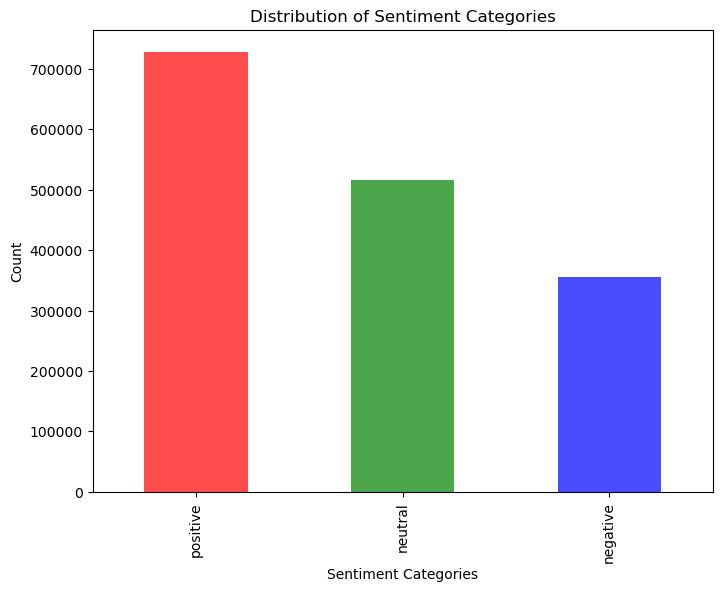

In [43]:

# You can use the 'label' column for sentiment categories

# Plotting the distribution histogram
plt.figure(figsize=(8, 6))
pandas_df['label'].value_counts().plot(kind='bar', color=['red', 'green', 'blue'], alpha=0.7)

# Adding labels and title
plt.title('Distribution of Sentiment Categories')
plt.xlabel('Sentiment Categories')
plt.ylabel('Count')

# Display the plot
plt.show()

In [83]:


# selecting 'sentiment' is the predicted sentiment column
predicted_labels = pandas_df['sentiment']

# Evaluate internal consistency since there are not true lables, only the predicted ones 

# First, if 'sentiment' is binary (0 and 1), you can check the distribution
print("Distribution of Predicted Sentiment:")
print(predicted_labels.value_counts())

# 
# Using internal consistency (percentage of consistent predictions) to measure model
internal_consistency = (predicted_labels == 0).mean()  # Adjust as needed
print(f"\nInternal Consistency: {internal_consistency * 100:.2f}%")

# If 'sentiment' is binary, you can also check the confusion matrix
# and classification report
conf_matrix = confusion_matrix(predicted_labels, predicted_labels)
class_report = classification_report(predicted_labels, predicted_labels)

print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)


Distribution of Predicted Sentiment:
1    881786
0    718214
Name: sentiment, dtype: int64

Internal Consistency: 44.89%


NameError: name 'confusion_matrix' is not defined

## Checking for missing values in the date column


Time series models work with complete data, and therefore they require the missing data to be replaced with meaningful values before actual analysis. At a high level, missing values in time series are handled in two ways, either dropping them or replacing them. However, dropping missing values can be an inappropriate solution due to the time order of the data and the correlation between observations in adjacent periods.

 *Imputation* replaces missing values with values estimated from the same data or observed from the environment with the same conditions underlying the missing data.

https://www.section.io/engineering-education/missing-values-in-time-series/#introduction

In [45]:
# Convert 'date' column to datetime type
pandas_df['date'] = pd.to_datetime(pandas_df['date'])

# Create a new column with the date only
pandas_df['date_only'] = pandas_df['date'].dt.date

# Check the frequency of daily records
daily_frequency = pandas_df['date_only'].value_counts().sort_index()

# Display the frequency of daily records
print("Daily Frequency:\n", daily_frequency)

# Identify missing dates
all_dates = pd.date_range(start=pandas_df['date_only'].min(), end=pandas_df['date_only'].max(), freq='D')
missing_dates = all_dates[~all_dates.isin(pandas_df['date_only'])]

# Display missing dates
print("\nMissing Dates:\n", missing_dates)

Daily Frequency:
 2009-04-07     20671
2009-04-18     17154
2009-04-19     32648
2009-04-20     18447
2009-04-21     11105
2009-05-02     31096
2009-05-03     26568
2009-05-04     28300
2009-05-10     31551
2009-05-11      6217
2009-05-12      4186
2009-05-14     21526
2009-05-17     41205
2009-05-18     44564
2009-05-22     41206
2009-05-24       169
2009-05-25       169
2009-05-27     11619
2009-05-29     60227
2009-05-30    104484
2009-05-31    105986
2009-06-01     95449
2009-06-02     77776
2009-06-03     60139
2009-06-04      4638
2009-06-05     34735
2009-06-06    104793
2009-06-07    111893
2009-06-08     18566
2009-06-14       500
2009-06-15     83309
2009-06-16     87524
2009-06-17     44031
2009-06-18     43322
2009-06-19     42964
2009-06-20     45582
2009-06-21     30677
2009-06-22      8313
2009-06-23     18605
2009-06-24      2093
2009-06-25     25993
Name: date_only, dtype: int64

Missing Dates:
 DatetimeIndex(['2009-04-08', '2009-04-09', '2009-04-10', '2009-04-11',
   

In [46]:
#Calculate the difference between the dates using delta function
from datetime import datetime

# Corrected date strings
d1_str = '2009-04-07'
d2_str = '2009-06-25'

# Convert date strings to datetime objects
d1 = datetime.strptime(d1_str, '%Y-%m-%d')
d2 = datetime.strptime(d2_str, '%Y-%m-%d')

# Difference between dates in timedelta
delta = d2 - d1
print(f'Difference is {delta.days} days')

Difference is 79 days


In [47]:
daily_frequency.info()

<class 'pandas.core.series.Series'>
Index: 41 entries, 2009-04-07 to 2009-06-25
Series name: date_only
Non-Null Count  Dtype
--------------  -----
41 non-null     int64
dtypes: int64(1)
memory usage: 656.0+ bytes


This code represents the date distribution and finding out with dates are missing for the data preparation. When dealing with time series analysis, we must have a complete dataset with all datapoints present in cronological order, otherwise the forecasting will be far less accurate and cause issues for the decision makers. 

   The date column has a range between <b/>2009-04-07 and 2009-06-25 </b>, which means there are 80 days to use in the timeseries. However, from the Daily Frequency output above, the dataset only containg tweets recorded over 41 days, meaning there are <b> 38 </b> days missing from the total range where there were no records of tweets,. To fix the date column with complete values, data imputation techniques have to be applied. This will be performed in a copy of the current dataframe, to avoid losing any data during the imputation.

In [48]:

#print(pandas_df.info())
pandas_df.head()

,index,date,text,sentiment,sentiment_score,label,date_only
0,0,2009-04-07 05:19:45,a11 thats bummer shoulda got david carr third day,0,-0.3818,negative,2009-04-07
1,1,2009-04-07 05:19:49,upset cant update facebook texting it11 might ...,0,-0.7269,negative,2009-04-07
2,2,2009-04-07 05:19:53,dived many time ball managed save rest go bound,1,0.4939,positive,2009-04-07
3,3,2009-04-07 05:19:57,whole body feel itchy like fire,1,-0.2500,negative,2009-04-07
4,4,2009-04-07 05:19:57,behaving im mad cant see,0,-0.4939,negative,2009-04-07


<Figure size 1200x800 with 0 Axes>

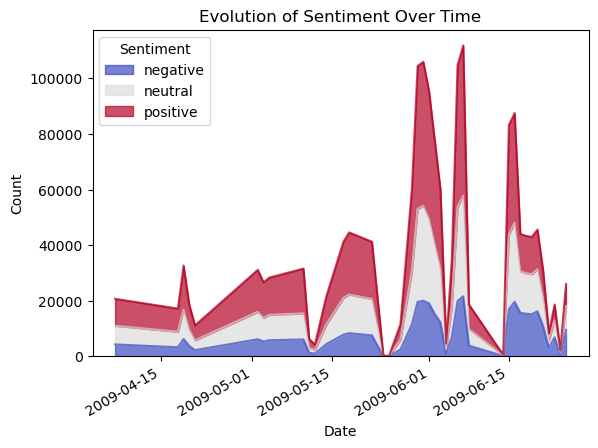

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert 'date_only' column to datetime type
pandas_df['date_only'] = pd.to_datetime(pandas_df['date_only'])

# Group by date and calculate the count of each sentiment category
sentiment_counts = pandas_df.groupby(['date_only', 'label']).size().unstack(fill_value=0)

# Plotting the evolution of sentiment over time
plt.figure(figsize=(12, 8))
sentiment_counts.plot(kind='area', stacked=True, colormap='coolwarm', alpha=0.7)

# Adding labels and title
plt.title('Evolution of Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend(title='Sentiment', loc='upper left')

# Display the plot
plt.show()

The data is grouped by date using value_counts(), and sort_index() is used to ensure the dates are sorted chronologically.

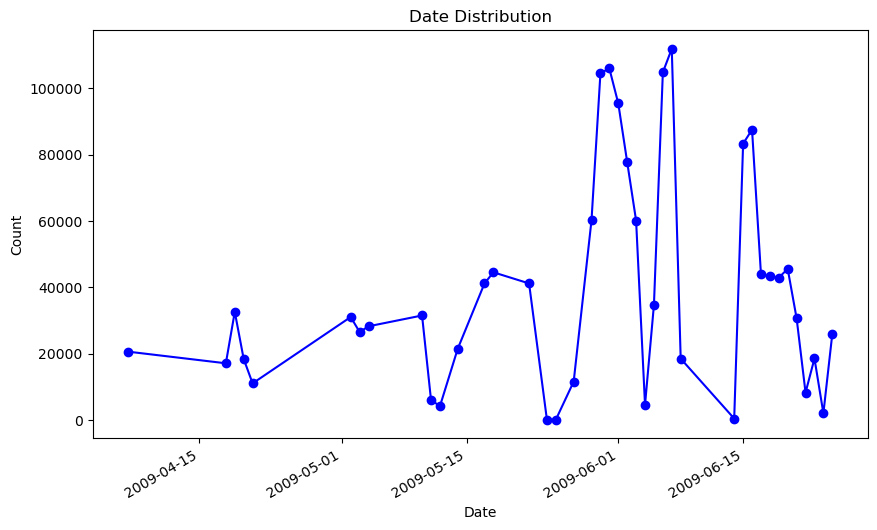

In [50]:


# Group by date and count the number of occurrences
date_distribution = pandas_df['date_only'].value_counts().sort_index()

# Plotting the line chart
plt.figure(figsize=(10, 6))
date_distribution.plot(kind='line', marker='o', linestyle='-', color='b')

# Adding labels and title
plt.title('Date Distribution')
plt.xlabel('Date')
plt.ylabel('Count')

# Display the plot
plt.show()


In [51]:
print(pandas_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 7 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   index            1600000 non-null  int32         
 1   date             1600000 non-null  datetime64[ns]
 2   text             1600000 non-null  object        
 3   sentiment        1600000 non-null  int64         
 4   sentiment_score  1600000 non-null  float64       
 5   label            1600000 non-null  object        
 6   date_only        1600000 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int32(1), int64(1), object(2)
memory usage: 79.3+ MB
None


## Copy numeric features to a new_df to input missing dates

This will create a new DataFrame (new_df) containing only the columns 'date_only', 'sentiment', and 'sentiment_score'. This way there will be only the numeric features needed for next stages. 
Note that there are still missing dates on the full range of data before doing the timeseries, first step is to add the complete range of 80 days between 2009-04-07 and 2009-06-25.

Once the numeric features are extracted from the original dataframe and stored in a copy,the missing dates registered in the lines above can be merged to the new_df. 




In [52]:
#create a copy of pandas_df extracting most important featueres for thies stage

selected_cols = ['date_only','sentiment','sentiment_score']

# Create a copy of the DataFrame with only selected columns
new_df = pandas_df[selected_cols].copy()


#display the new dataframe:
new_df.head()


,date_only,sentiment,sentiment_score
0,2009-04-07,0,-0.3818
1,2009-04-07,0,-0.7269
2,2009-04-07,1,0.4939
3,2009-04-07,1,-0.2500
4,2009-04-07,0,-0.4939


In [53]:
print(new_df.dtypes)

date_only          datetime64[ns]
sentiment                   int64
sentiment_score           float64
dtype: object


After doublechecking all features are in correct datatype, is possible to extract some more from the data.

The descriptive statisctics from the sentiment_score column shows a wide range of sentiment scores, with a moderate level of variability. The majority of scores are around 0, suggesting a neutral or mildly positive sentiment, while the 75th percentile indicates a notable proportion of positive sentiment scores.

### Storing new_df with sentiment scores back to HDFS

As a safety measure for version control, in case the vm starts to run out of space agian, the new dataframe containg only the dates and sentiment scores will be stored on a new csv file back in hdfs. 

A few techniques to free up space in ubuntu were atempted also, but they damanged some of the packages previously installed (sklearn as the most important for next stages of the project). a new virtual env was created were the missing packages are working aparently, so if necessary the labeled data can be imported to a separate Jupyter Notebook to prevent the progress if the kernel presents any issues. this is due the sentimental analysis codes wih nltk, specially the tokenization and lemmetization codes have a high time of execution of nearly 20 min to run (Total execution time: 1124.5174362659454 seconds as the time function outputs in previous steps.)

In [58]:
# Assuming your DataFrame is named 'new_df'
output_path_downloads = "/home/hduser/Downloads/SentimentData.csv"

# Save the DataFrame to a CSV file in the Downloads folder
new_df.to_csv(output_path_downloads, index=False)

Was not able to use the same code as before, system required :~$ pip install fsspec
error: externally-managed-environment

So the solution was to save the file first to my Downloads folder and from that use a subpreocess to copy the SentimentData back to HDFS.


In [59]:
import subprocess

#  local file path
local_file_path = "/home/hduser/Downloads/SentimentData.csv"
# Assuming the HDFS directory
hdfs_directory = "hdfs:///user/hduser/CA2"

# Use subprocess to run the hdfs dfs -copyFromLocal command
subprocess.run(["hdfs", "dfs", "-copyFromLocal", local_file_path, hdfs_directory])

2023-11-21 10:48:45,453 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
copyFromLocal: `hdfs:///user/hduser/CA2/SentimentData.csv': File exists


CompletedProcess(args=['hdfs', 'dfs', '-copyFromLocal', '/home/hduser/Downloads/SentimentData.csv', 'hdfs:///user/hduser/CA2'], returncode=1)

In [54]:
new_df['sentiment_score'].describe()

count    1.600000e+06
mean     1.481301e-01
std      4.275047e-01
min     -9.985000e-01
25%      0.000000e+00
50%      0.000000e+00
75%      4.939000e-01
max      9.987000e-01
Name: sentiment_score, dtype: float64

In [55]:
missing_dates

DatetimeIndex(['2009-04-08', '2009-04-09', '2009-04-10', '2009-04-11',
               '2009-04-12', '2009-04-13', '2009-04-14', '2009-04-15',
               '2009-04-16', '2009-04-17', '2009-04-22', '2009-04-23',
               '2009-04-24', '2009-04-25', '2009-04-26', '2009-04-27',
               '2009-04-28', '2009-04-29', '2009-04-30', '2009-05-01',
               '2009-05-05', '2009-05-06', '2009-05-07', '2009-05-08',
               '2009-05-09', '2009-05-13', '2009-05-15', '2009-05-16',
               '2009-05-19', '2009-05-20', '2009-05-21', '2009-05-23',
               '2009-05-26', '2009-05-28', '2009-06-09', '2009-06-10',
               '2009-06-11', '2009-06-12', '2009-06-13'],
              dtype='datetime64[ns]', freq=None)

In [60]:
#Merging missing dates to copy of new_df

# Step 1: Calculate average sentiment score for each day
average_sentiment_per_day = new_df.groupby('date_only')['sentiment_score'].mean().reset_index()

# Step 2: Create a DataFrame with the complete date range with daily freq='D'
complete_date_range = pd.date_range(start=new_df['date_only'].min(), end=new_df['date_only'].max(), freq='D')
complete_df = pd.DataFrame({'date_only': complete_date_range})

# Step 3: Merge the original DataFrame with the complete DataFrame
merged_df = pd.merge(complete_df, new_df, on='date_only', how='left')

# Step 4: Fill in missing sentiment values with the corresponding daily average
merged_df['sentiment'] = merged_df.groupby('date_only')['sentiment'].transform(lambda x: x.fillna(x.mean()))

# Display the merged DataFrame
print(merged_df.head())
print(merged_df.info())
print(merged_df.describe())



   date_only  sentiment  sentiment_score
0 2009-04-07        0.0          -0.3818
1 2009-04-07        0.0          -0.7269
2 2009-04-07        1.0           0.4939
3 2009-04-07        1.0          -0.2500
4 2009-04-07        0.0          -0.4939
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600039 entries, 0 to 1600038
Data columns (total 3 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   date_only        1600039 non-null  datetime64[ns]
 1   sentiment        1600000 non-null  float64       
 2   sentiment_score  1600000 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 48.8 MB
None
          sentiment  sentiment_score
count  1.600000e+06     1.600000e+06
mean   5.511162e-01     1.481301e-01
std    4.973804e-01     4.275047e-01
min    0.000000e+00    -9.985000e-01
25%    0.000000e+00     0.000000e+00
50%    1.000000e+00     0.000000e+00
75%    1.000000e+00     4.939000e-01
max   

In [61]:
average_sentiments_per_day = new_df.groupby('date_only')[['sentiment', 'sentiment_score']].mean().reset_index()
print(average_sentiments_per_day.head())

   date_only  sentiment  sentiment_score
0 2009-04-07   0.560931         0.163041
1 2009-04-18   0.570946         0.186187
2 2009-04-19   0.571582         0.185831
3 2009-04-20   0.571041         0.178536
4 2009-04-21   0.570194         0.177462


In [62]:
merged_df.isnull().sum()

date_only           0
sentiment          39
sentiment_score    39
dtype: int64

In [63]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600039 entries, 0 to 1600038
Data columns (total 3 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   date_only        1600039 non-null  datetime64[ns]
 1   sentiment        1600000 non-null  float64       
 2   sentiment_score  1600000 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 48.8 MB


In [64]:
merged_df

,date_only,sentiment,sentiment_score
0,2009-04-07,0.0,-0.3818
1,2009-04-07,0.0,-0.7269
2,2009-04-07,1.0,0.4939
3,2009-04-07,1.0,-0.2500
4,2009-04-07,0.0,-0.4939
...,...,...,...
1600034,2009-06-25,0.0,-0.5106
1600035,2009-06-25,0.0,0.0000
1600036,2009-06-25,1.0,0.1027
1600037,2009-06-25,1.0,0.3612


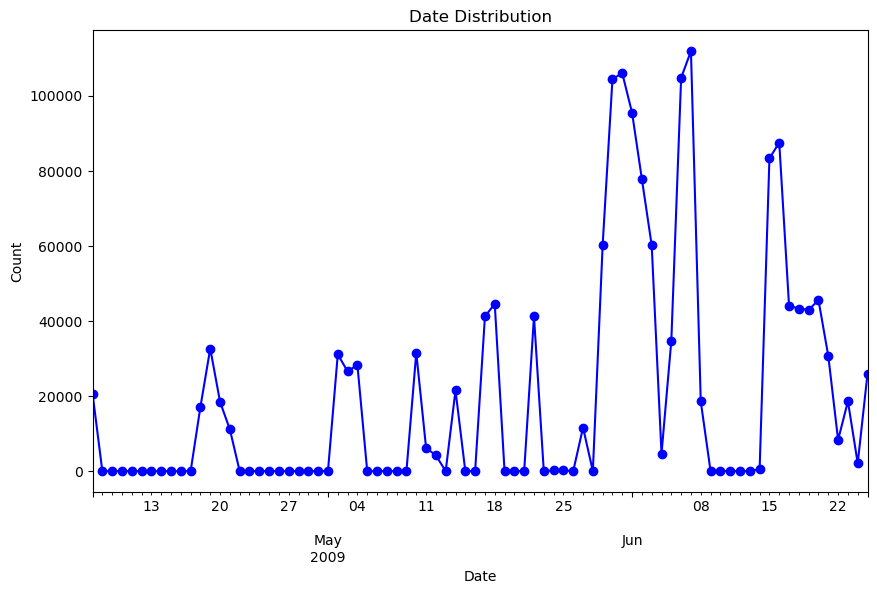

In [65]:

# Group by date and count the number of occurrences
date_distribution2 = merged_df['date_only'].value_counts().sort_index()

# Plotting the line chart
plt.figure(figsize=(10, 6))
date_distribution2.plot(kind='line', marker='o', linestyle='-', color='b')

# Adding labels and title
plt.title('Date Distribution')
plt.xlabel('Date')
plt.ylabel('Count')

# Display the plot
plt.show()


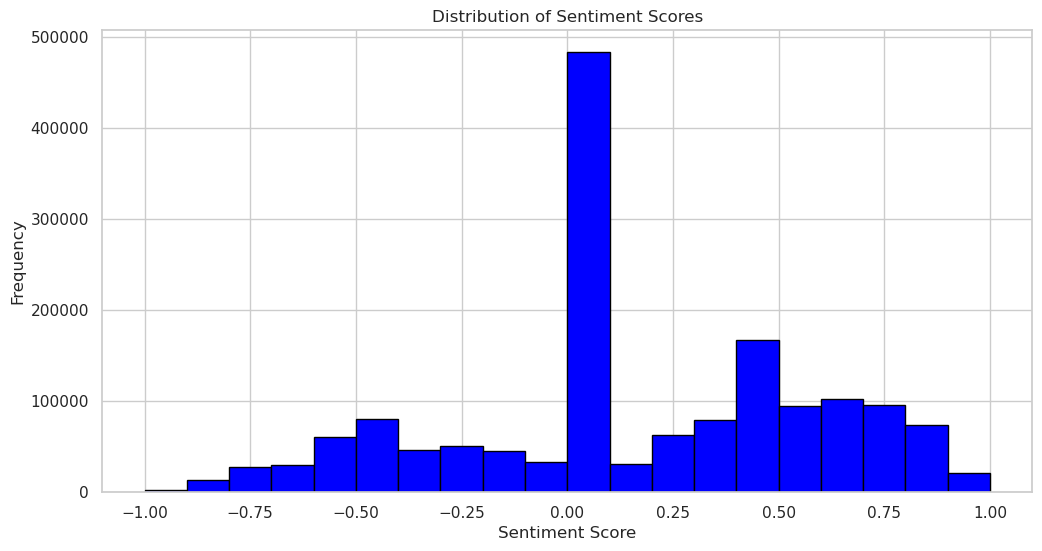

In [78]:
# Assuming 'merged_df' is your DataFrame
plt.figure(figsize=(12, 6))
plt.hist(merged_df['sentiment_score'], bins=20, range=(-1, 1), color='blue', edgecolor='black')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### Fill in missing sentiment score values with different methods: mean, median, and linear interpolation



In [66]:

# Assuming 'new_df' is your original DataFrame with 'date_only' and 'sentiment_score' columns
# Ensure 'date_only' is of datetime type

# Step 1: Calculate average sentiment score for each day
average_sentiment_per_day = new_df.groupby('date_only')['sentiment_score'].mean().reset_index()

# Step 2: Create a DataFrame with the complete date range with daily freq='D'
complete_date_range = pd.date_range(start=new_df['date_only'].min(), end=new_df['date_only'].max(), freq='D')
complete_df = pd.DataFrame({'date_only': complete_date_range})

# Step 3: Merge the original DataFrame with the complete DataFrame
merged_df1 = pd.merge(complete_df, new_df, on='date_only', how='left')


# Step 4: Fill in missing sentiment values with different methods: mean, median, and linear interpolation
merged_df1['sentiment_mean'] = merged_df1.groupby('date_only')['sentiment_score'].transform('mean').fillna(method='ffill').fillna(method='bfill')
merged_df1['sentiment_median'] = merged_df1.groupby('date_only')['sentiment_score'].transform('median').fillna(method='ffill').fillna(method='bfill')
merged_df1['sentiment_interpolated'] = merged_df1['sentiment_score'].interpolate(method='linear')


# Display the merged DataFrame
print(merged_df1.head())
print(merged_df1.info())
print(merged_df1.describe())


   date_only  sentiment  sentiment_score  sentiment_mean  sentiment_median  \
0 2009-04-07        0.0          -0.3818        0.163041               0.0   
1 2009-04-07        0.0          -0.7269        0.163041               0.0   
2 2009-04-07        1.0           0.4939        0.163041               0.0   
3 2009-04-07        1.0          -0.2500        0.163041               0.0   
4 2009-04-07        0.0          -0.4939        0.163041               0.0   

   sentiment_interpolated  
0                 -0.3818  
1                 -0.7269  
2                  0.4939  
3                 -0.2500  
4                 -0.4939  
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600039 entries, 0 to 1600038
Data columns (total 6 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   date_only               1600039 non-null  datetime64[ns]
 1   sentiment               1600000 non-null  float64       
 2 

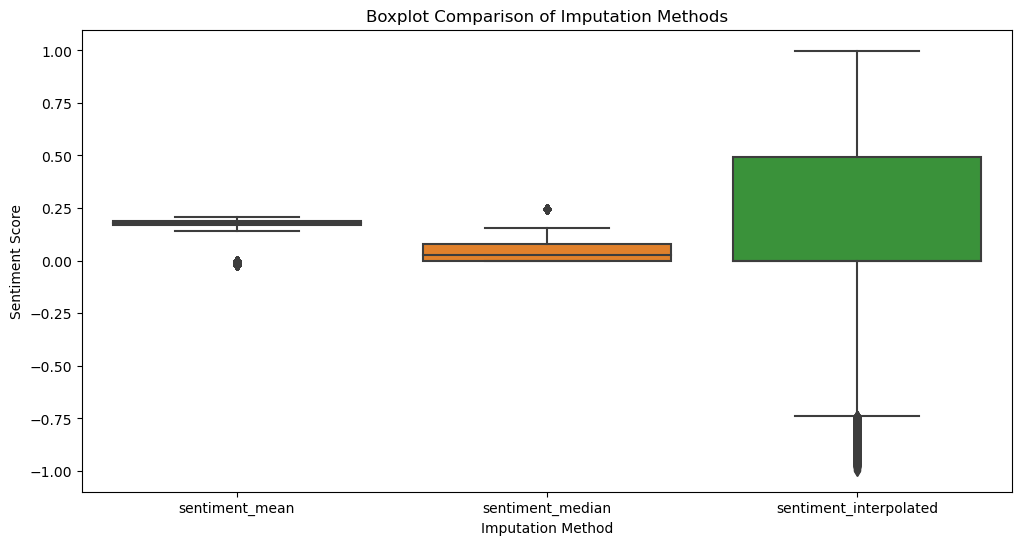

In [67]:
# Boxplot comparison
plt.figure(figsize=(12, 6))
sns.boxplot(data=merged_df1[['sentiment_mean', 'sentiment_median', 'sentiment_interpolated']])
plt.title('Boxplot Comparison of Imputation Methods')
plt.xlabel('Imputation Method')
plt.ylabel('Sentiment Score')
plt.show()

For some reason, all the imputations seems to have the same output, it turns out only the interpolation was being used to fill in, the adjusted code in merged_df1 shows all the new imputations compared. The next line used a random datethat was originally missing to see the different results from the imputation:


In [68]:
#checking a random missing date to see if imputation was succesfull in the last 3 columns:
specific_date = '2009-04-30'
specific_date_data = merged_df1[merged_df1['date_only'] == specific_date]

specific_date_data

,date_only,sentiment,sentiment_score,sentiment_mean,sentiment_median,sentiment_interpolated
100043,2009-04-30,NaN,NaN,0.177462,0.0258,0.590309


In [69]:
merged_df1.describe()

,sentiment,sentiment_score,sentiment_mean,sentiment_median,sentiment_interpolated
count,1.600000e+06,1.600000e+06,1.600039e+06,1.600039e+06,1.600039e+06
mean,5.511162e-01,1.481301e-01,1.481307e-01,3.770923e-02,1.481293e-01
std,4.973804e-01,4.275047e-01,7.198514e-02,3.730605e-02,4.275030e-01
min,0.000000e+00,-9.985000e-01,-2.287802e-02,0.000000e+00,-9.985000e-01
25%,0.000000e+00,0.000000e+00,1.671769e-01,0.000000e+00,0.000000e+00
50%,1.000000e+00,0.000000e+00,1.780257e-01,2.580000e-02,0.000000e+00
75%,1.000000e+00,4.939000e-01,1.866179e-01,7.720000e-02,4.939000e-01
max,1.000000e+00,9.987000e-01,2.080554e-01,2.435000e-01,9.987000e-01


In [70]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600039 entries, 0 to 1600038
Data columns (total 3 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   date_only        1600039 non-null  datetime64[ns]
 1   sentiment        1600000 non-null  float64       
 2   sentiment_score  1600000 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 48.8 MB


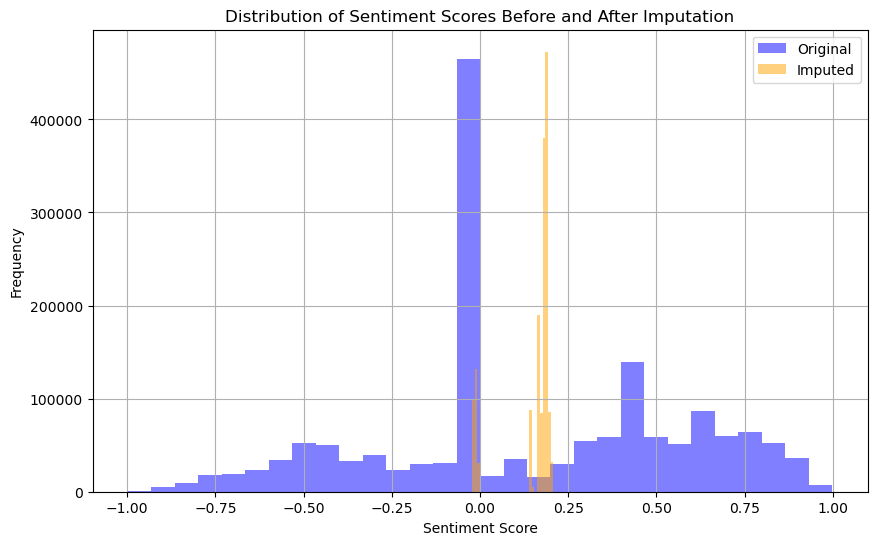

In [71]:
# Create a histogram for original sentiment scores
plt.figure(figsize=(10, 6))
plt.hist(merged_df1['sentiment_score'].dropna(), bins=30, alpha=0.5, label='Original', color='blue')

# Create a histogram for imputed sentiment scores
plt.hist(merged_df1['sentiment_mean'].dropna(), bins=30, alpha=0.5, label='Imputed', color='orange')

# Customize plot
plt.title('Distribution of Sentiment Scores Before and After Imputation')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

In [72]:
# Step 1: Calculate average sentiment score for each day
average_sentiment_per_day = new_df.groupby('date_only')['sentiment_score'].mean().reset_index()

# Step 2: Create a DataFrame with the complete date range with daily freq='D'
complete_date_range = pd.date_range(start=new_df['date_only'].min(), end=new_df['date_only'].max(), freq='D')
complete_df = pd.DataFrame({'date_only': complete_date_range})

# Step 3: Merge the original DataFrame with the complete DataFrame
merged_df2 = pd.merge(complete_df, new_df, on='date_only', how='left')

# Step 4: Fill in missing sentiment values with the corresponding daily average
merged_df2['sentiment_score'] = merged_df2['sentiment_score'].fillna(new_df['sentiment_score'].mean())

# Display the merged DataFrame
print(merged_df2.head())
print(merged_df2.info())

   date_only  sentiment  sentiment_score
0 2009-04-07        0.0          -0.3818
1 2009-04-07        0.0          -0.7269
2 2009-04-07        1.0           0.4939
3 2009-04-07        1.0          -0.2500
4 2009-04-07        0.0          -0.4939
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600039 entries, 0 to 1600038
Data columns (total 3 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   date_only        1600039 non-null  datetime64[ns]
 1   sentiment        1600000 non-null  float64       
 2   sentiment_score  1600039 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 48.8 MB
None


In [73]:
merged_df2.isnull().sum()

date_only           0
sentiment          39
sentiment_score     0
dtype: int64

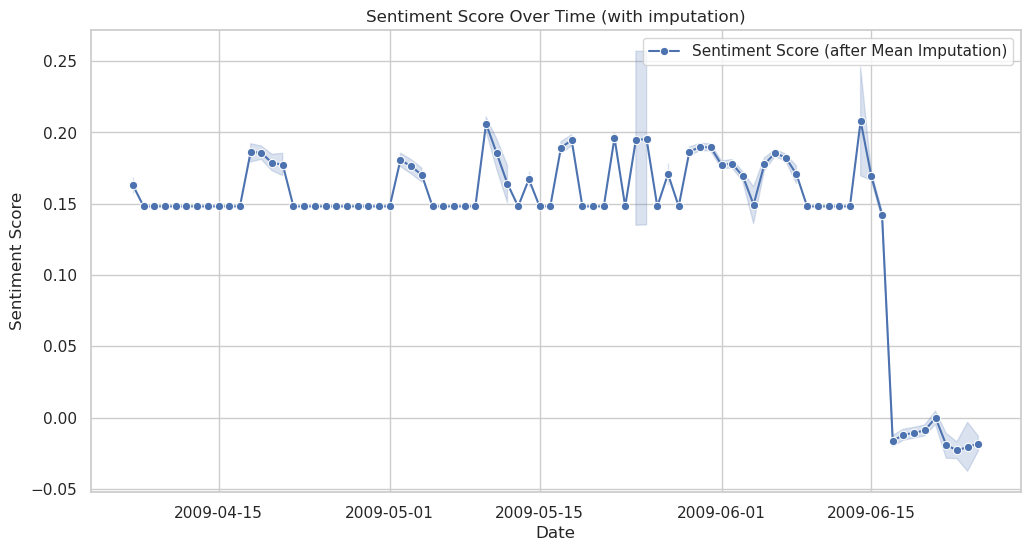

In [74]:
import seaborn as sns

# Set the style of seaborn
sns.set(style="whitegrid")

# Create a line plot using Seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(x='date_only', y='sentiment_score', data=merged_df2, label='Sentiment Score (after Mean Imputation)', marker='o')

# Customize plot
plt.title('Sentiment Score Over Time (with imputation)')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.legend()
plt.show()

In [76]:
#Calculate average sentiment score for each day for after imputation
average_sentiment = merged_df2.groupby('date_only')['sentiment_score'].mean().reset_index()
average_sentiment.head()

,date_only,sentiment_score
0,2009-04-07,0.163041
1,2009-04-08,0.148130
2,2009-04-09,0.148130
3,2009-04-10,0.148130
4,2009-04-11,0.148130


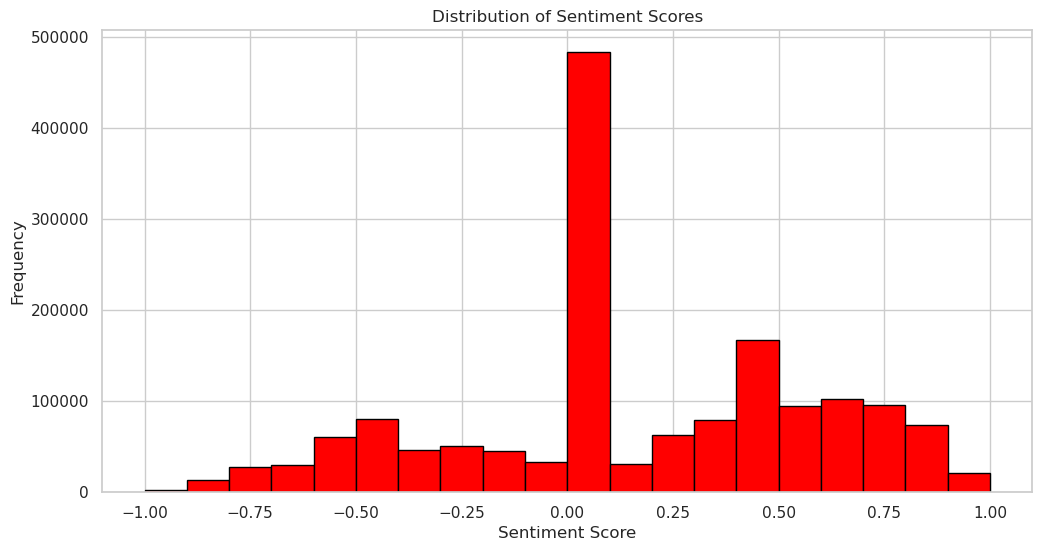

In [79]:
# Assuming 'merged_df' is your DataFrame
plt.figure(figsize=(12, 6))
plt.hist(merged_df2['sentiment_score'], bins=20, range=(-1, 1), color='red', edgecolor='black')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### Using the first merged_df1 to check how the values are distributed:


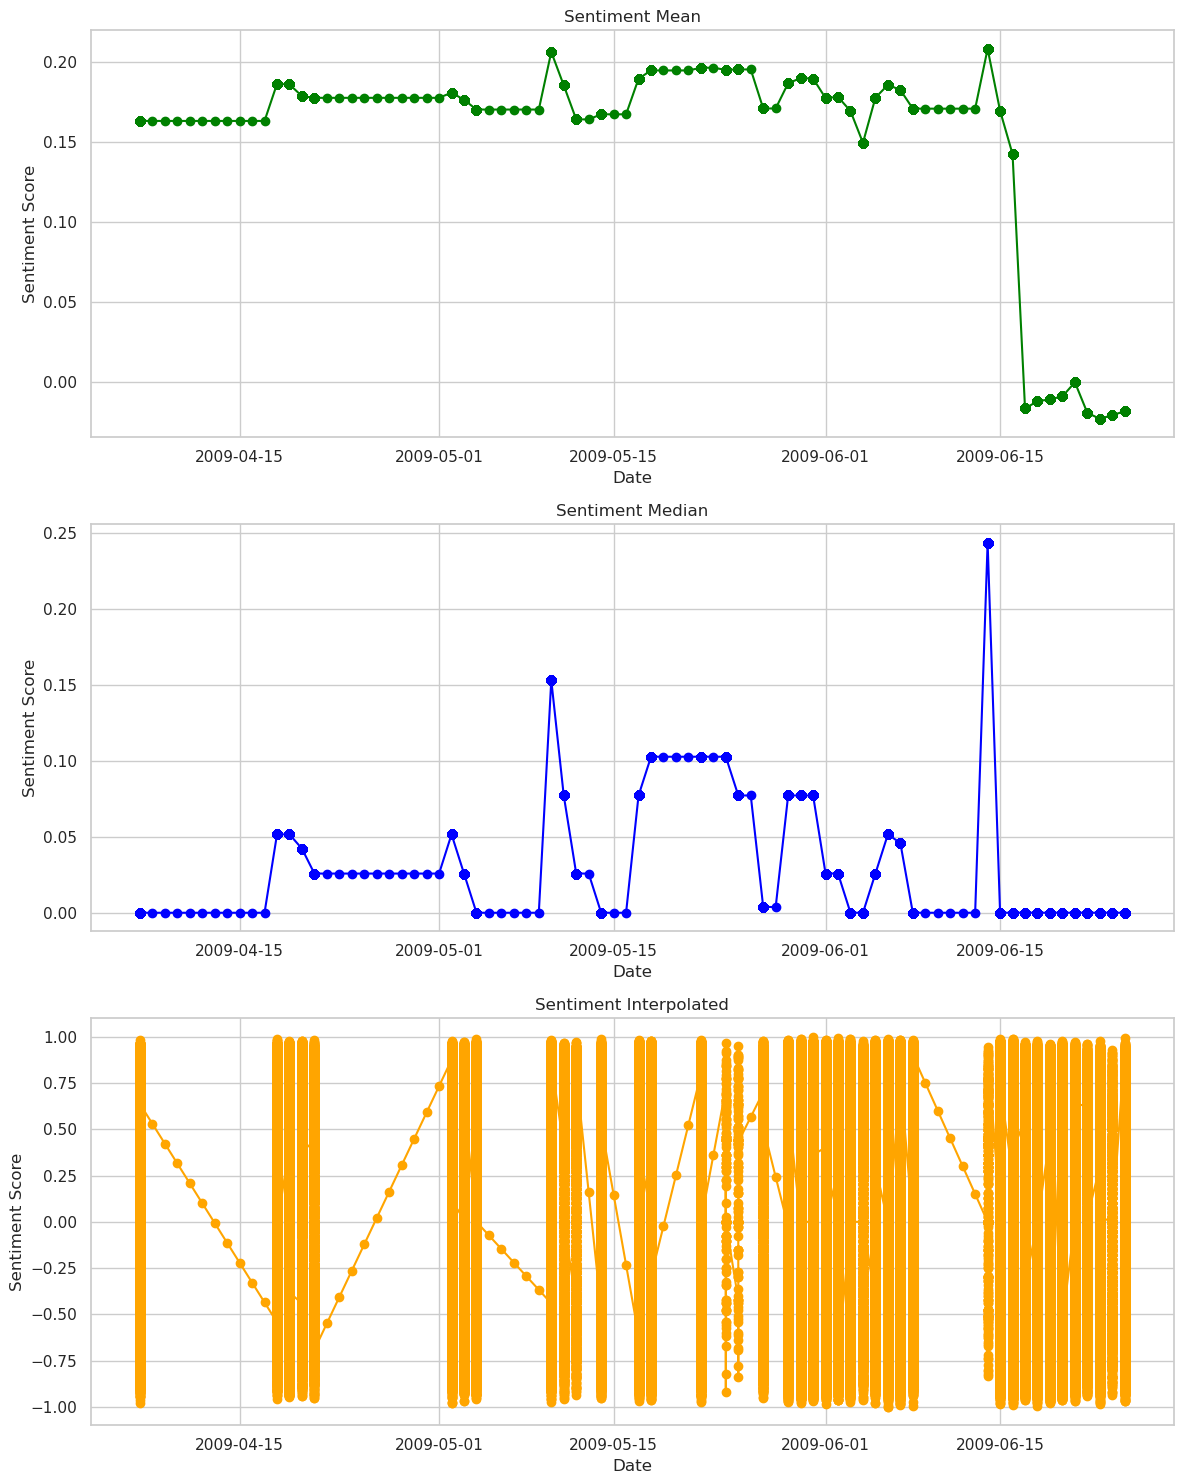

In [80]:
# Create subplots for each sentiment inputation
fig, axes = plt.subplots(3, 1, figsize=(12, 15))

# Plot for Sentiment Mean
axes[0].plot(merged_df1['date_only'], merged_df1['sentiment_mean'], marker='o', linestyle='-', color='green')
axes[0].set_title('Sentiment Mean')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Sentiment Score')

# Plot for Sentiment Median
axes[1].plot(merged_df1['date_only'], merged_df1['sentiment_median'], marker='o', linestyle='-', color='blue')
axes[1].set_title('Sentiment Median')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Sentiment Score')

# Plot for Sentiment Interpolated
axes[2].plot(merged_df1['date_only'], merged_df1['sentiment_interpolated'], marker='o', linestyle='-', color='orange')
axes[2].set_title('Sentiment Interpolated')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Sentiment Score')

# Adjust layout
plt.tight_layout()
plt.show()

In [88]:
merged_df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600039 entries, 0 to 1600038
Data columns (total 3 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   date_only        1600039 non-null  datetime64[ns]
 1   sentiment        1600000 non-null  float64       
 2   sentiment_score  1600039 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 48.8 MB


In [90]:
# Assuming your DataFrame is named 'new_df'
output_path_downloads = "/home/hduser/Downloads/ImputData.csv"

# Save the DataFrame to a CSV file in the Downloads folder
merged_df2.to_csv(output_path_downloads, index=False)

In [91]:
#Store the complete dataframe with the imputations of missing values back in hdfs as well.

import subprocess

# Assuming the local file path
local_file_path = "/home/hduser/Downloads/ImputData.csv"
# Assuming the HDFS directory
hdfs_directory = "hdfs:///user/hduser/CA2"

# Use subprocess to run the hdfs dfs -copyFromLocal command
subprocess.run(["hdfs", "dfs", "-copyFromLocal", local_file_path, hdfs_directory])

2023-11-21 11:45:06,132 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


CompletedProcess(args=['hdfs', 'dfs', '-copyFromLocal', '/home/hduser/Downloads/ImputData.csv', 'hdfs:///user/hduser/CA2'], returncode=0)

## Data preparation for Time Series Models

When attempeted to free up space 

In [93]:
#!pip3 install statsmodels

# 

error: externally-managed-environment

× This environment is externally managed
╰─> To install Python packages system-wide, try apt install
    python3-xyz, where xyz is the package you are trying to
    install.
    
    If you wish to install a non-Debian-packaged Python package,
    create a virtual environment using python3 -m venv path/to/venv.
    Then use path/to/venv/bin/python and path/to/venv/bin/pip. Make
    sure you have python3-full installed.
    
    If you wish to install a non-Debian packaged Python application,
    it may be easiest to use pipx install xyz, which will manage a
    virtual environment for you. Make sure you have pipx installed.
    
    See /usr/share/doc/python3.11/README.venv for more information.

note: If you believe this is a mistake, please contact your Python installation or OS distribution provider. You can override this, at the risk of breaking your Python installation or OS, by passing --break-system-packages.
hint: See PEP 668 for the detai

In [1]:

from statsmodels.tsa.seasonal import seasonal_decompose


ModuleNotFoundError: No module named 'statsmodels.tsa.seasonal'

In [2]:

# Shapiro-Wilk test for normality
shapiro_stat, shapiro_pvalue = stats.shapiro(melted_df)
print(f'Shapiro-Wilk test statistic: {shapiro_stat}')
print(f'Shapiro-Wilk test p-value: {shapiro_pvalue}')

NameError: name 'stats' is not defined

In [ ]:
#!pip install vaderSentiment
#error: externally-managed-environment

- store cleaned dataset back to hbase/mysql


#### Importing dataset from HBase using a Connector.

#### Sentiment extration using SparkNLP library/pipeline

The sentiment analysis results will be stored in the 'sentiment.result' column once the data is preprocessed.

This pipeline uses the DocumentAssembler to assemble the words into documents, which is required for the Spark NLP SentimentDetector. Then, it applies the sentiment analysis using the trained model.

In [ ]:
#!pip install sparknlp

In [ ]:
#from sparknlp.pretrained import PretrainedPipeline

#pipeline = PretrainedPipeline("analyze_sentiment")

In [ ]:
#from pyspark.sql.functions import lit

# Assuming your existing DataFrame is named `tweets_df` and tokenized words are in the column "words"
# Add a label column (e.g., 1 for positive, 0 for negative)
#labeled_df = tweets_df.withColumn("label", lit(1))  # possibvle to customize this based on sentiment classes

In [ ]:
#from pyspark.sql.functions import concat_ws

# Combine tokenized words into a single column
#labeled_df = labeled_df.withColumn("combined_text", concat_ws(" ", "words"))

In [ ]:
#from sparknlp.annotator import SentimentDetector

# SentimentDetector setup
#sentiment_detector = SentimentDetector() \
 #   .setInputCols(["combined_text", "words"]) \
   # .setOutputCol("sentiment")

# Create a new pipeline with the SentimentDetector
#pipeline_sentiment = Pipeline(stages=[sentiment_detector])

# Apply sentiment detection
#analyzed_df = pipeline_sentiment.fit(labeled_df).transform(labeled_df)

# Show the results
#analyzed_df.select("combined_text", "sentiment.result", "label").show(truncate=False)
